In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка результатов

## **Изучение полученных результатов из УМ**

In [2]:
def get_result(config:str,
               way_type:str,
               fault:str,
               speed:int,
               profile:str = "gost") ->pd.DataFrame:
    """
    Получение результатов расчетов по ключевым словам
    1. `config` принимает два вида строк `empty` и `loaded`
    2. `way_type` принимает три вида строк `straight`, `curve_350` и `curve_650`
    3. `fault` принимает три вида строк `normal`, `polzun15`, `ellips10`
    4. `speed` от 10 до 60 км/ч
    5. `profile` есть профили `gost`, `newwagonw`, `greb_26`, `greb_30`, `greb_28`
    """
    dictionary = {"curve_350":{20:55,
                               30:39,
                               40:28,
                               50:24,
                               60:19},
                }
    if config == "empty":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\empty"
    
    elif config == "loaded":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\loaded"
    
    name = "\\"+config+"_"+way_type+"_"+fault+"_"+str(speed)+"_"+profile+".csv"

    l_name = len(name)

    FULL_PATH = PATH+name

    file = pd.read_csv(FULL_PATH,encoding='latin-1')

    COL_NAMES = ["time_step",name[1:l_name-4]]

    file.columns = COL_NAMES

    file = file.set_index("time_step")

    if config == "curve_350":
        file = file[file.index<dictionary["curve_350"][speed]]

    
    return file


In [3]:
def get_profile_results(config:str,
                        way_type:str,
                        fault:str,
                        speed:int):
    """Результаты расчета по всем видам профилей"""
    file1 = get_result(config, way_type,fault,speed)
    file2 = get_result(config, way_type,fault,speed, "greb_26")
    file3 = get_result(config, way_type,fault,speed, "greb_28")
    file4 = get_result(config, way_type,fault,speed, "greb_30")
    file5 = get_result(config, way_type,fault,speed, "newwagonw")

    return file1,file2,file3,file4,file5

In [4]:
def plot_profile_results(config:str,way_type:str,fault:str,speed:int):
    """Создание графика сравнения результатов с разным профилем колес"""
    d={"loaded":"Груженый",
       "empty":"Порожний",
       "straight":"прямая",
       "curve_350":"кривая 350 м",
       "curve_650":"кривая 650 м",
       "normal":"без неисправностей",
       "polzun15":"ползун",
       "ellips10":"неравномерный прокат"}
    
   #  sns.set (rc={' axes.facecolor':'#C0C0C0', 'figure.facecolor':'#FFFFF0 '})
    
    files = get_profile_results(config, way_type,fault,speed)
    FILE = pd.concat(files,axis=1)
    FILE.columns = ["gost","greb_26","greb_28","greb_30","newwagonw"]

    plt.figure(figsize=(12,8))
    plt.grid(True)
    sns.lineplot(FILE)
    plt.title(f"{d[config]} вагон, {d[way_type]}, {d[fault]} скорость {speed} км/ч ")
    plt.xlabel("Время, с")
    plt.ylabel("Вертикальная сила, Н")
    plt.show()
    



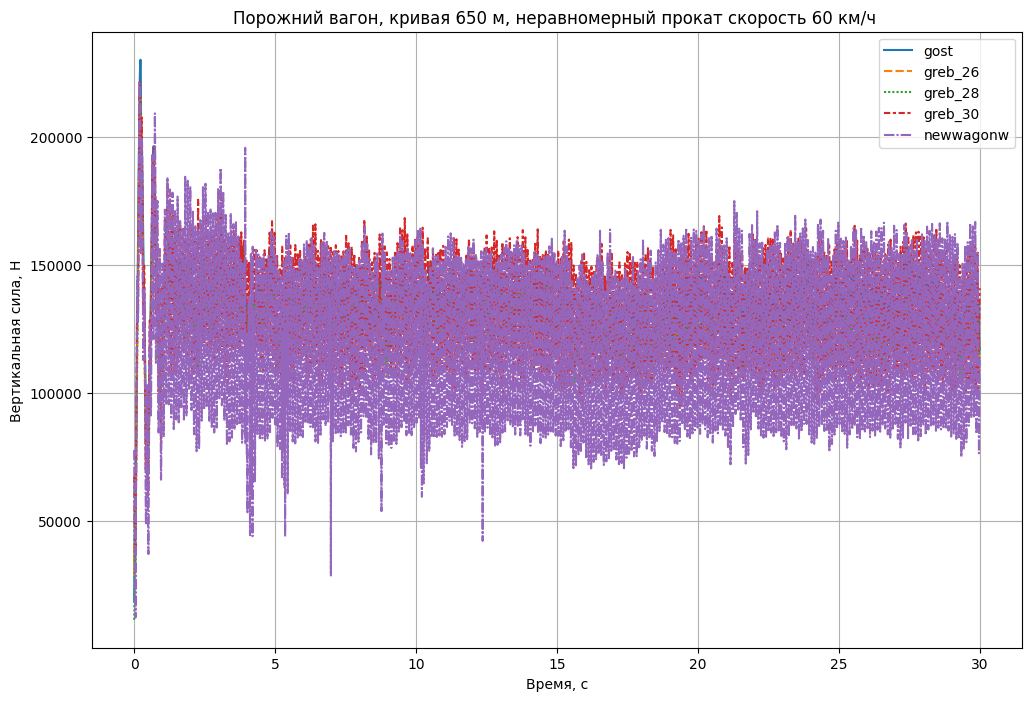

In [5]:
plot_profile_results("empty","curve_650","ellips10",60)

In [6]:
empty_straight_normal_10 = get_result("empty","straight","normal",10)
empty_straight_normal_10.head()

,empty_straight_normal_10_gost
time_step,
0.000000,29575.992
0.005109,32467.777
0.010109,35095.023
0.015109,38440.480
0.020109,41884.520


In [7]:
empty_straight_normal_20 = get_result("empty","straight","normal",20)
empty_straight_normal_20.head()

,empty_straight_normal_20_gost
time_step,
0.000000,29575.992
0.005109,32136.971
0.010109,35086.570
0.015109,39165.609
0.020109,43360.832


In [8]:
def get_speed_results(config:str,
                      way_type:str,
                      fault:str,
                      profile:str = "gost") -> list[pd.DataFrame]:
    speed = [i for i in range(10,70,10)]

    results = []

    for v in speed:
        file = get_result(config,way_type,fault,profile=profile,speed=v)
        results.append(file)
    
    return results

In [9]:
# Все результаты расчетов по всем параметрам

## Порожний вагон, прямая, без неисправностей
empty_straight_normal_gost = get_speed_results("empty","straight","normal")
empty_straight_normal_greb_26 = get_speed_results("empty","straight","normal","greb_26")
empty_straight_normal_greb_28 = get_speed_results("empty","straight","normal", "greb_28")
empty_straight_normal_greb_30 = get_speed_results("empty","straight","normal", "greb_30")

## Порожний вагон, прямая, ползун 1,5 мм
empty_straight_polzun15_gost = get_speed_results("empty","straight","polzun15")
empty_straight_polzun15_greb_26 = get_speed_results("empty","straight","polzun15","greb_26")
empty_straight_polzun15_greb_28 = get_speed_results("empty","straight","polzun15", "greb_28")
empty_straight_polzun15_greb_30 = get_speed_results("empty","straight","polzun15", "greb_30")

## Порожний вагон, прямая, эллипс 10 мм
empty_straight_ellips10_gost = get_speed_results("empty","straight","ellips10")
empty_straight_ellips10_greb_26 = get_speed_results("empty","straight","ellips10","greb_26")
empty_straight_ellips10_greb_28 = get_speed_results("empty","straight","ellips10", "greb_28")
empty_straight_ellips10_greb_30 = get_speed_results("empty","straight","ellips10", "greb_30")



## Порожний вагон, кривая 350 м, без неисправностей
empty_curve_350_normal_gost = get_speed_results("empty","curve_350","normal")
empty_curve_350_normal_greb_26 = get_speed_results("empty","curve_350","normal","greb_26")
empty_curve_350_normal_greb_28 = get_speed_results("empty","curve_350","normal", "greb_28")
empty_curve_350_normal_greb_30 = get_speed_results("empty","curve_350","normal", "greb_30")

## Порожний вагон, кривая 350 м, ползун 1,5 мм
empty_curve_350_polzun15_gost = get_speed_results("empty","curve_350","polzun15")
empty_curve_350_polzun15_greb_26 = get_speed_results("empty","curve_350","polzun15","greb_26")
empty_curve_350_polzun15_greb_28 = get_speed_results("empty","curve_350","polzun15", "greb_28")
empty_curve_350_polzun15_greb_30 = get_speed_results("empty","curve_350","polzun15", "greb_30")

## Порожний вагон, кривая 350 м, эллипс 10 мм
empty_curve_350_ellips10_gost = get_speed_results("empty","curve_350","ellips10")
empty_curve_350_ellips10_greb_26 = get_speed_results("empty","curve_350","ellips10","greb_26")
empty_curve_350_ellips10_greb_28 = get_speed_results("empty","curve_350","ellips10", "greb_28")
empty_curve_350_ellips10_greb_30 = get_speed_results("empty","curve_350","ellips10", "greb_30")



## Порожний вагон, кривая 650 м, без неисправностей
empty_curve_650_normal_gost = get_speed_results("empty","curve_650","normal")
empty_curve_650_normal_greb_26 = get_speed_results("empty","curve_650","normal","greb_26")
empty_curve_650_normal_greb_28 = get_speed_results("empty","curve_650","normal", "greb_28")
empty_curve_650_normal_greb_30 = get_speed_results("empty","curve_650","normal", "greb_30")

## Порожний вагон, кривая 650 м, ползун 1,5 мм
empty_curve_650_polzun15_gost = get_speed_results("empty","curve_650","polzun15")
empty_curve_650_polzun15_greb_26 = get_speed_results("empty","curve_650","polzun15","greb_26")
empty_curve_650_polzun15_greb_28 = get_speed_results("empty","curve_650","polzun15", "greb_28")
empty_curve_650_polzun15_greb_30 = get_speed_results("empty","curve_650","polzun15", "greb_30")

## Порожний вагон, кривая 650 м, эллипс 10 мм
empty_curve_650_ellips10_gost = get_speed_results("empty","curve_650","ellips10")
empty_curve_650_ellips10_greb_26 = get_speed_results("empty","curve_650","ellips10","greb_26")
empty_curve_650_ellips10_greb_28 = get_speed_results("empty","curve_650","ellips10", "greb_28")
empty_curve_650_ellips10_greb_30 = get_speed_results("empty","curve_650","ellips10", "greb_30")


#-----------------Груженый вагон----------------


## Груженый вагон, прямая, без неисправностей
loaded_straight_normal_gost = get_speed_results("loaded","straight","normal")
loaded_straight_normal_greb_26 = get_speed_results("loaded","straight","normal","greb_26")
loaded_straight_normal_greb_28 = get_speed_results("loaded","straight","normal", "greb_28")
loaded_straight_normal_greb_30 = get_speed_results("loaded","straight","normal", "greb_30")

## Груженый вагон, прямая, ползун 1,5 мм
loaded_straight_polzun15_gost = get_speed_results("loaded","straight","polzun15")
loaded_straight_polzun15_greb_26 = get_speed_results("loaded","straight","polzun15","greb_26")
loaded_straight_polzun15_greb_28 = get_speed_results("loaded","straight","polzun15", "greb_28")
loaded_straight_polzun15_greb_30 = get_speed_results("loaded","straight","polzun15", "greb_30")

## Груженый вагон, прямая, эллипс 10 мм
loaded_straight_ellips10_gost = get_speed_results("loaded","straight","ellips10")
loaded_straight_ellips10_greb_26 = get_speed_results("loaded","straight","ellips10","greb_26")
loaded_straight_ellips10_greb_28 = get_speed_results("loaded","straight","ellips10", "greb_28")
loaded_straight_ellips10_greb_30 = get_speed_results("loaded","straight","ellips10", "greb_30")



## Груженый вагон, кривая 350 м, без неисправностей
loaded_curve_350_normal_gost = get_speed_results("loaded","curve_350","normal")
loaded_curve_350_normal_greb_26 = get_speed_results("loaded","curve_350","normal","greb_26")
loaded_curve_350_normal_greb_28 = get_speed_results("loaded","curve_350","normal", "greb_28")
loaded_curve_350_normal_greb_30 = get_speed_results("loaded","curve_350","normal", "greb_30")

## Груженый вагон, кривая 350 м, ползун 1,5 мм
loaded_curve_350_polzun15_gost = get_speed_results("loaded","curve_350","polzun15")
loaded_curve_350_polzun15_greb_26 = get_speed_results("loaded","curve_350","polzun15","greb_26")
loaded_curve_350_polzun15_greb_28 = get_speed_results("loaded","curve_350","polzun15", "greb_28")
loaded_curve_350_polzun15_greb_30 = get_speed_results("loaded","curve_350","polzun15", "greb_30")

## Груженый вагон, кривая 350 м, эллипс 10 мм
loaded_curve_350_ellips10_gost = get_speed_results("loaded","curve_350","ellips10")
loaded_curve_350_ellips10_greb_26 = get_speed_results("loaded","curve_350","ellips10","greb_26")
loaded_curve_350_ellips10_greb_28 = get_speed_results("loaded","curve_350","ellips10", "greb_28")
loaded_curve_350_ellips10_greb_30 = get_speed_results("loaded","curve_350","ellips10", "greb_30")



## Груженый вагон, кривая 650 м, без неисправностей
loaded_curve_650_normal_gost = get_speed_results("loaded","curve_650","normal")
loaded_curve_650_normal_greb_26 = get_speed_results("loaded","curve_650","normal","greb_26")
loaded_curve_650_normal_greb_28 = get_speed_results("loaded","curve_650","normal", "greb_28")
loaded_curve_650_normal_greb_30 = get_speed_results("loaded","curve_650","normal", "greb_30")

## Груженый вагон, кривая 650 м, ползун 1,5 мм
loaded_curve_650_polzun15_gost = get_speed_results("loaded","curve_650","polzun15")
loaded_curve_650_polzun15_greb_26 = get_speed_results("loaded","curve_650","polzun15","greb_26")
loaded_curve_650_polzun15_greb_28 = get_speed_results("loaded","curve_650","polzun15", "greb_28")
loaded_curve_650_polzun15_greb_30 = get_speed_results("loaded","curve_650","polzun15", "greb_30")

## Груженый вагон, кривая 650 м, эллипс 10 мм
loaded_curve_650_ellips10_gost = get_speed_results("loaded","curve_650","ellips10")
loaded_curve_650_ellips10_greb_26 = get_speed_results("loaded","curve_650","ellips10","greb_26")
loaded_curve_650_ellips10_greb_28 = get_speed_results("loaded","curve_650","ellips10", "greb_28")
loaded_curve_650_ellips10_greb_30 = get_speed_results("loaded","curve_650","ellips10", "greb_30")


## **Подготовка инфы для разделения на кастомные фолды**

Так как колесо по ГОСТ имеет радиус 475 мм, то полный оборот колеса fold = 2*pi*475

Тогда время прохождения полного оборота колеса будет равно t = fold/v 

In [74]:
def time_split(v:int) -> int:
    """Определение временного промежутка полного оборота колеса
    1. v - скорость движения поезда, км/ч
    """
    speed = v/3.6
    lenght = 2*np.pi*0.475
    t = lenght/speed
    return t

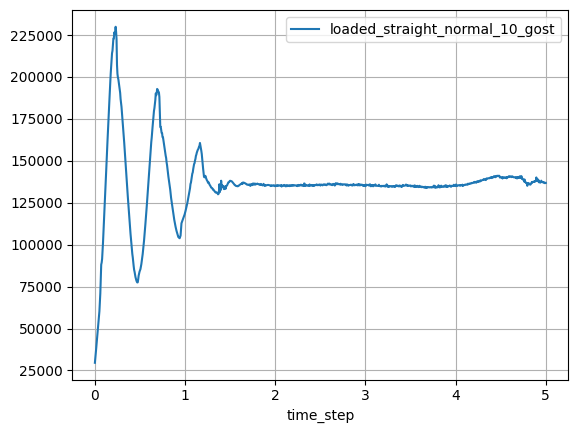

In [75]:
plt.grid(True)
sns.lineplot(loaded_straight_normal_gost[0])
plt.show()

In [76]:
def get_time_splits(data:pd.DataFrame) -> list:
    """Возвращает индексы по которым нужно производить обрез
    Индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = []

    start_point = 1.4

    time_max_point = data.index.max()               # Максимальное время

    if data.columns[0].split("_")[1] == "straight":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[3])) # 1.007 сек

    elif data.columns[0].split("_")[1] == "curve":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[4])) # 1.007 сек
        
    num_folds = (time_max_point-1)//wheel_rotate_num    # Сколько всего фолдов получится сделать

    res.append(start_point)

    for _ in range(int(num_folds)):
        start_point+= wheel_rotate_num
        res.append(start_point)

    return res

In [77]:
def time_indexes(frames:list[pd.DataFrame]) -> dict:
    """Возвращает словарь индексов по которым нужно производить обрез, где
    индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = {}

    for n in range(len(frames)):
        name = frames[n].columns[0]

        res[name] = get_time_splits(frames[n])
    
    return res

In [78]:
time_indexes(empty_straight_normal_gost)

{'empty_straight_normal_10_gost': [1.4,
  2.4744246875277094,
  3.5488493750554184,
  4.6232740625831275],
 'empty_straight_normal_20_gost': [1.4,
  1.9372123437638544,
  2.474424687527709,
  3.0116370312915635,
  3.548849375055418,
  4.0860617188192725,
  4.6232740625831275,
  5.160486406346982],
 'empty_straight_normal_30_gost': [1.4,
  1.7581415625092363,
  2.1162831250184726,
  2.474424687527709,
  2.8325662500369453,
  3.1907078125461816,
  3.548849375055418,
  3.9069909375646543,
  4.265132500073891,
  4.6232740625831275,
  4.981415625092364,
  5.3395571876016],
 'empty_straight_normal_40_gost': [1.4,
  1.6686061718819272,
  1.9372123437638544,
  2.205818515645782,
  2.4744246875277094,
  2.743030859409637,
  3.0116370312915643,
  3.280243203173492,
  3.5488493750554193,
  3.817455546937347,
  4.086061718819274,
  4.354667890701202,
  4.623274062583129,
  4.891880234465057,
  5.160486406346984],
 'empty_straight_normal_50_gost': [1.4,
  1.6148849375055419,
  1.8297698750110838,
 

In [79]:
# Получение индексов полного оборота колеса

##------------Порожний вагон---------------
## Порожний вагон, прямая, без неисправностей
indexes_empty_straight_normal_gost = time_indexes(empty_straight_normal_gost)
indexes_empty_straight_normal_greb_26 = time_indexes(empty_straight_normal_greb_26)
indexes_empty_straight_normal_greb_28 = time_indexes(empty_straight_normal_greb_28)
indexes_empty_straight_normal_greb_30 = time_indexes(empty_straight_normal_greb_30)

## Порожний вагон, прямая, ползун 1,5 мм
indexes_empty_straight_polzun15_gost = time_indexes(empty_straight_polzun15_gost)
indexes_empty_straight_polzun15_greb_26 = time_indexes(empty_straight_polzun15_greb_26)
indexes_empty_straight_polzun15_greb_28 = time_indexes(empty_straight_polzun15_greb_28)
indexes_empty_straight_polzun15_greb_30 = time_indexes(empty_straight_polzun15_greb_30)

## Порожний вагон, прямая, эллипс 10 мм
indexes_empty_straight_ellips10_gost = time_indexes(empty_straight_ellips10_gost)
indexes_empty_straight_ellips10_greb_26 = time_indexes(empty_straight_ellips10_greb_26)
indexes_empty_straight_ellips10_greb_28 = time_indexes(empty_straight_ellips10_greb_28)
indexes_empty_straight_ellips10_greb_30 = time_indexes(empty_straight_ellips10_greb_30)

## Порожний вагон, кривая 350 м, без неисправностей
indexes_empty_curve_350_normal_gost = time_indexes(empty_curve_350_normal_gost)
indexes_empty_curve_350_normal_greb_26 = time_indexes(empty_curve_350_normal_greb_26)
indexes_empty_curve_350_normal_greb_28 = time_indexes(empty_curve_350_normal_greb_28)
indexes_empty_curve_350_normal_greb_30 = time_indexes(empty_curve_350_normal_greb_30)

## Порожний вагон, кривая 350 м, ползун 1,5 мм
indexes_empty_curve_350_polzun15_gost = time_indexes(empty_curve_350_polzun15_gost)
indexes_empty_curve_350_polzun15_greb_26 = time_indexes(empty_curve_350_polzun15_greb_26)
indexes_empty_curve_350_polzun15_greb_28 = time_indexes(empty_curve_350_polzun15_greb_28)
indexes_empty_curve_350_polzun15_greb_30 = time_indexes(empty_curve_350_polzun15_greb_30)

## Порожний вагон, кривая 350 м, эллипс 10 мм
indexes_empty_curve_350_ellips10_gost = time_indexes(empty_curve_350_ellips10_gost)
indexes_empty_curve_350_ellips10_greb_26 = time_indexes(empty_curve_350_ellips10_greb_26)
indexes_empty_curve_350_ellips10_greb_28 = time_indexes(empty_curve_350_ellips10_greb_28)
indexes_empty_curve_350_ellips10_greb_30 = time_indexes(empty_curve_350_ellips10_greb_30)


## Порожний вагон, кривая 650 м, без неисправностей
indexes_empty_curve_650_normal_gost = time_indexes(empty_curve_650_normal_gost)
indexes_empty_curve_650_normal_greb_26 = time_indexes(empty_curve_650_normal_greb_26)
indexes_empty_curve_650_normal_greb_28 = time_indexes(empty_curve_650_normal_greb_28)
indexes_empty_curve_650_normal_greb_30 = time_indexes(empty_curve_650_normal_greb_30)

## Порожний вагон, кривая 650 м, ползун 1,5 мм
indexes_empty_curve_650_polzun15_gost = time_indexes(empty_curve_650_polzun15_gost)
indexes_empty_curve_650_polzun15_greb_26 = time_indexes(empty_curve_650_polzun15_greb_26)
indexes_empty_curve_650_polzun15_greb_28 = time_indexes(empty_curve_650_polzun15_greb_28)
indexes_empty_curve_650_polzun15_greb_30 = time_indexes(empty_curve_650_polzun15_greb_30)

## Порожний вагон, кривая 650 м, эллипс 10 мм
indexes_empty_curve_650_ellips10_gost = time_indexes(empty_curve_650_ellips10_gost)
indexes_empty_curve_650_ellips10_greb_26 = time_indexes(empty_curve_650_ellips10_greb_26)
indexes_empty_curve_650_ellips10_greb_28 = time_indexes(empty_curve_650_ellips10_greb_28)
indexes_empty_curve_650_ellips10_greb_30 = time_indexes(empty_curve_650_ellips10_greb_30)


##------------Груженый вагон---------------

## Груженый вагон, прямая, без неисправностей
indexes_loaded_straight_normal_gost = time_indexes(loaded_straight_normal_gost)
indexes_loaded_straight_normal_greb_26 = time_indexes(loaded_straight_normal_greb_26)
indexes_loaded_straight_normal_greb_28 = time_indexes(loaded_straight_normal_greb_28)
indexes_loaded_straight_normal_greb_30 = time_indexes(loaded_straight_normal_greb_30)

## Груженый вагон, прямая, ползун 1,5 мм
indexes_loaded_straight_polzun15_gost = time_indexes(loaded_straight_polzun15_gost)
indexes_loaded_straight_polzun15_greb_26 = time_indexes(loaded_straight_polzun15_greb_26)
indexes_loaded_straight_polzun15_greb_28 = time_indexes(loaded_straight_polzun15_greb_28)
indexes_loaded_straight_polzun15_greb_30 = time_indexes(loaded_straight_polzun15_greb_30)

## Груженый вагон, прямая, эллипс 10 мм
indexes_loaded_straight_ellips10_gost = time_indexes(loaded_straight_ellips10_gost)
indexes_loaded_straight_ellips10_greb_26 = time_indexes(loaded_straight_ellips10_greb_26)
indexes_loaded_straight_ellips10_greb_28 = time_indexes(loaded_straight_ellips10_greb_28)
indexes_loaded_straight_ellips10_greb_30 = time_indexes(loaded_straight_ellips10_greb_30)

## Груженый вагон, кривая 350 м, без неисправностей
indexes_loaded_curve_350_normal_gost = time_indexes(loaded_curve_350_normal_gost)
indexes_loaded_curve_350_normal_greb_26 = time_indexes(loaded_curve_350_normal_greb_26)
indexes_loaded_curve_350_normal_greb_28 = time_indexes(loaded_curve_350_normal_greb_28)
indexes_loaded_curve_350_normal_greb_30 = time_indexes(loaded_curve_350_normal_greb_30)

## Груженый вагон, кривая 350 м, ползун 1,5 мм
indexes_loaded_curve_350_polzun15_gost = time_indexes(loaded_curve_350_polzun15_gost)
indexes_loaded_curve_350_polzun15_greb_26 = time_indexes(loaded_curve_350_polzun15_greb_26)
indexes_loaded_curve_350_polzun15_greb_28 = time_indexes(loaded_curve_350_polzun15_greb_28)
indexes_loaded_curve_350_polzun15_greb_30 = time_indexes(loaded_curve_350_polzun15_greb_30)

## Груженый вагон, кривая 350 м, эллипс 10 мм
indexes_loaded_curve_350_ellips10_gost = time_indexes(loaded_curve_350_ellips10_gost)
indexes_loaded_curve_350_ellips10_greb_26 = time_indexes(loaded_curve_350_ellips10_greb_26)
indexes_loaded_curve_350_ellips10_greb_28 = time_indexes(loaded_curve_350_ellips10_greb_28)
indexes_loaded_curve_350_ellips10_greb_30 = time_indexes(loaded_curve_350_ellips10_greb_30)


## Груженый вагон, кривая 650 м, без неисправностей
indexes_loaded_curve_650_normal_gost = time_indexes(loaded_curve_650_normal_gost)
indexes_loaded_curve_650_normal_greb_26 = time_indexes(loaded_curve_650_normal_greb_26)
indexes_loaded_curve_650_normal_greb_28 = time_indexes(loaded_curve_650_normal_greb_28)
indexes_loaded_curve_650_normal_greb_30 = time_indexes(loaded_curve_650_normal_greb_30)

## Груженый вагон, кривая 650 м, ползун 1,5 мм
indexes_loaded_curve_650_polzun15_gost = time_indexes(loaded_curve_650_polzun15_gost)
indexes_loaded_curve_650_polzun15_greb_26 = time_indexes(loaded_curve_650_polzun15_greb_26)
indexes_loaded_curve_650_polzun15_greb_28 = time_indexes(loaded_curve_650_polzun15_greb_28)
indexes_loaded_curve_650_polzun15_greb_30 = time_indexes(loaded_curve_650_polzun15_greb_30)

## Груженый вагон, кривая 650 м, эллипс 10 мм
indexes_loaded_curve_650_ellips10_gost = time_indexes(loaded_curve_650_ellips10_gost)
indexes_loaded_curve_650_ellips10_greb_26 = time_indexes(loaded_curve_650_ellips10_greb_26)
indexes_loaded_curve_650_ellips10_greb_28 = time_indexes(loaded_curve_650_ellips10_greb_28)
indexes_loaded_curve_650_ellips10_greb_30 = time_indexes(loaded_curve_650_ellips10_greb_30)

In [80]:
indexes_empty_straight_polzun15_gost

{'empty_straight_polzun15_10_gost': [1.4,
  2.4744246875277094,
  3.5488493750554184,
  4.6232740625831275],
 'empty_straight_polzun15_20_gost': [1.4,
  1.9372123437638544,
  2.474424687527709,
  3.0116370312915635,
  3.548849375055418,
  4.0860617188192725,
  4.6232740625831275,
  5.160486406346982],
 'empty_straight_polzun15_30_gost': [1.4,
  1.7581415625092363,
  2.1162831250184726,
  2.474424687527709,
  2.8325662500369453,
  3.1907078125461816,
  3.548849375055418,
  3.9069909375646543,
  4.265132500073891,
  4.6232740625831275,
  4.981415625092364,
  5.3395571876016],
 'empty_straight_polzun15_40_gost': [1.4,
  1.6686061718819272,
  1.9372123437638544,
  2.205818515645782,
  2.4744246875277094,
  2.743030859409637,
  3.0116370312915643,
  3.280243203173492,
  3.5488493750554193,
  3.817455546937347,
  4.086061718819274,
  4.354667890701202,
  4.623274062583129,
  4.891880234465057,
  5.160486406346984],
 'empty_straight_polzun15_50_gost': [1.4,
  1.6148849375055419,
  1.829769875

In [81]:
def get_splited_dataframe(data:pd.DataFrame,indexes:list) -> pd.DataFrame:
    """Разделение одного результата расчета на несколько других по полному обороту колеса
    1. `data` - датафрейм с расчетом
    2. `indexes` - индексы по которым нужно делить расчет"""
    
    zeros = np.zeros((214,1))
    common_df = pd.DataFrame(zeros)

    for i in range(len(indexes)):
        if i < len(indexes) - 1:
            seq = data[(data.index>=indexes[i]) & (data.index<=indexes[i+1])]  # срез по точкам
        else:
            seq = data[data.index>indexes[i]]
        common_df = pd.concat([common_df,seq], axis=1)
    
    df = common_df.drop(0, axis=1)
    num_cols = len(df.columns)

    df.columns = [[data.columns[0] for i in range(num_cols)],[i for i in range(num_cols)]]
    
    return df       

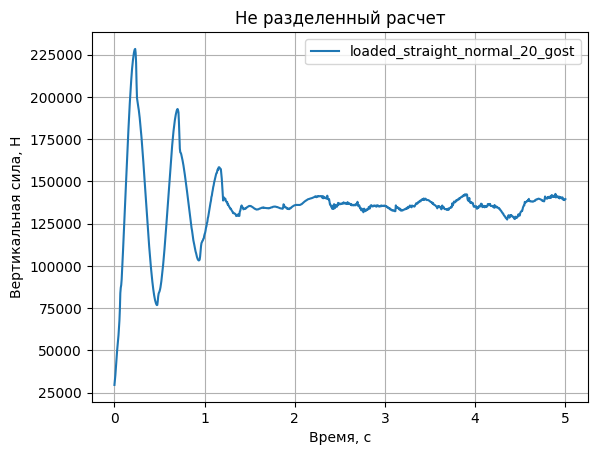

In [82]:
plt.grid(True)
sns.lineplot(loaded_straight_normal_gost[1])
plt.title("Не разделенный расчет")
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.show()

**Пример разделения расчета на несколько мелких по обороту колеса**

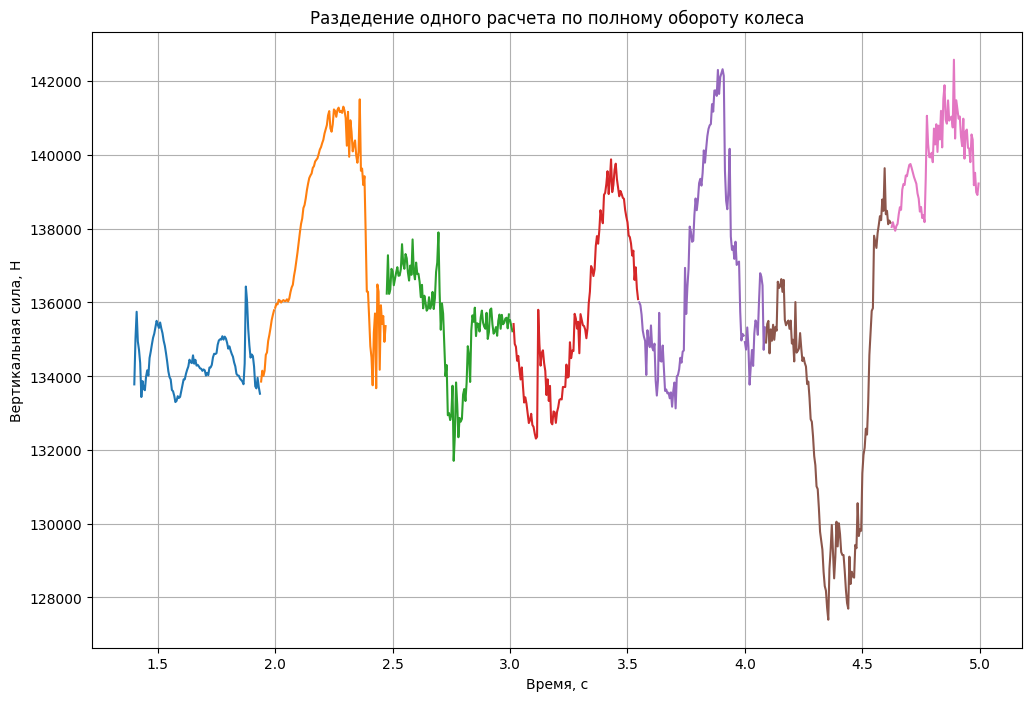

In [83]:
devided_result = get_splited_dataframe(loaded_straight_normal_gost[1], indexes_loaded_straight_normal_gost["loaded_straight_normal_20_gost"])

plt.figure().set_size_inches(12,8)
plt.grid(True)
plt.plot(devided_result)
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.title("Раздедение одного расчета по полному обороту колеса")
plt.show()

In [89]:
devided_result["loaded_straight_normal_20_gost"][0].dropna()

1.400109    133778.13
1.405109    135011.69
1.410109    135746.75
1.415109    134943.42
1.420109    134714.48
              ...    
1.915109    133725.41
1.920109    133670.08
1.925109    133956.02
1.930109    133706.13
1.935109    133524.89
Name: 0, Length: 108, dtype: float64

**Идея с преобразованием Фурье, как доп фичи**

In [93]:
np.fft.fft(devided_result["loaded_straight_normal_20_gost"][0].dropna(),10)

array([ 1.34313172e+06   +0.j        , -7.05819003e+00-4581.17942905j,
       -1.41374934e+03 -702.86401007j, -1.20901181e+03 -679.56034413j,
        1.88639337e+02 +897.20419964j, -4.68060000e+02   +0.j        ,
        1.88639337e+02 -897.20419964j, -1.20901181e+03 +679.56034413j,
       -1.41374934e+03 +702.86401007j, -7.05819003e+00+4581.17942905j])

In [26]:
devided_result["empty_curve_650_normal_60_gost"][0].describe()

count        36.000000
mean     140713.983889
std        3660.055525
min      135643.580000
25%      137529.535000
50%      140584.710000
75%      142782.132500
max      147676.300000
Name: 0, dtype: float64

In [ ]:
# Все разделенные расчеты
# Много кода по обработке каждого расчета
# ...

**Описание данных фолдов**

In [95]:
loaded_calculations = [loaded_straight_normal_gost,
                       loaded_straight_normal_greb_26,
                       loaded_straight_normal_greb_28,
                       loaded_straight_normal_greb_30,
                       loaded_curve_350_normal_gost,
                       loaded_curve_350_normal_greb_26,
                       loaded_curve_350_normal_greb_28,
                       loaded_curve_350_normal_greb_30,
                       loaded_curve_650_normal_gost,
                       loaded_curve_650_normal_greb_26,
                       loaded_curve_650_normal_greb_28,
                       loaded_curve_650_normal_greb_30,
                       loaded_straight_polzun15_gost,
                       loaded_straight_polzun15_greb_26,
                       loaded_straight_polzun15_greb_28,
                       loaded_straight_polzun15_greb_30,
                       loaded_curve_350_polzun15_gost,
                       loaded_curve_350_polzun15_greb_26,
                       loaded_curve_350_polzun15_greb_28,
                       loaded_curve_350_polzun15_greb_30,
                       loaded_curve_650_polzun15_gost,
                       loaded_curve_650_polzun15_greb_26,
                       loaded_curve_650_polzun15_greb_28,
                       loaded_curve_650_polzun15_greb_30,
                       loaded_straight_ellips10_gost,
                       loaded_straight_ellips10_greb_26,
                       loaded_straight_ellips10_greb_28,
                       loaded_straight_ellips10_greb_30,
                       loaded_curve_350_ellips10_gost,
                       loaded_curve_350_ellips10_greb_26,
                       loaded_curve_350_ellips10_greb_28,
                       loaded_curve_350_ellips10_greb_30,
                       loaded_curve_650_ellips10_gost,
                       loaded_curve_650_ellips10_greb_26,
                       loaded_curve_650_ellips10_greb_28,
                       loaded_curve_650_ellips10_greb_30]

empty_calculations = [empty_straight_normal_gost,
                       empty_straight_normal_greb_26,
                       empty_straight_normal_greb_28,
                       empty_straight_normal_greb_30,
                       empty_curve_350_normal_gost,
                       empty_curve_350_normal_greb_26,
                       empty_curve_350_normal_greb_28,
                       empty_curve_350_normal_greb_30,
                       empty_curve_650_normal_gost,
                       empty_curve_650_normal_greb_26,
                       empty_curve_650_normal_greb_28,
                       empty_curve_650_normal_greb_30,
                       empty_straight_polzun15_gost,
                       empty_straight_polzun15_greb_26,
                       empty_straight_polzun15_greb_28,
                       empty_straight_polzun15_greb_30,
                       empty_curve_350_polzun15_gost,
                       empty_curve_350_polzun15_greb_26,
                       empty_curve_350_polzun15_greb_28,
                       empty_curve_350_polzun15_greb_30,
                       empty_curve_650_polzun15_gost,
                       empty_curve_650_polzun15_greb_26,
                       empty_curve_650_polzun15_greb_28,
                       empty_curve_650_polzun15_greb_30,
                       empty_straight_ellips10_gost,
                       empty_straight_ellips10_greb_26,
                       empty_straight_ellips10_greb_28,
                       empty_straight_ellips10_greb_30,
                       empty_curve_350_ellips10_gost,
                       empty_curve_350_ellips10_greb_26,
                       empty_curve_350_ellips10_greb_28,
                       empty_curve_350_ellips10_greb_30,
                       empty_curve_650_ellips10_gost,
                       empty_curve_650_ellips10_greb_26,
                       empty_curve_650_ellips10_greb_28,
                       empty_curve_650_ellips10_greb_30]

loaded_indexes = [indexes_loaded_straight_normal_gost,
                    indexes_loaded_straight_normal_greb_26,
                    indexes_loaded_straight_normal_greb_28,
                    indexes_loaded_straight_normal_greb_30,
                    indexes_loaded_curve_350_normal_gost,
                    indexes_loaded_curve_350_normal_greb_26,
                    indexes_loaded_curve_350_normal_greb_28,
                    indexes_loaded_curve_350_normal_greb_30,
                    indexes_loaded_curve_650_normal_gost,
                    indexes_loaded_curve_650_normal_greb_26,
                    indexes_loaded_curve_650_normal_greb_28,
                    indexes_loaded_curve_650_normal_greb_30,
                    indexes_loaded_straight_polzun15_gost,
                    indexes_loaded_straight_polzun15_greb_26,
                    indexes_loaded_straight_polzun15_greb_28,
                    indexes_loaded_straight_polzun15_greb_30,
                    indexes_loaded_curve_350_polzun15_gost,
                    indexes_loaded_curve_350_polzun15_greb_26,
                    indexes_loaded_curve_350_polzun15_greb_28,
                    indexes_loaded_curve_350_polzun15_greb_30,
                    indexes_loaded_curve_650_polzun15_gost,
                    indexes_loaded_curve_650_polzun15_greb_26,
                    indexes_loaded_curve_650_polzun15_greb_28,
                    indexes_loaded_curve_650_polzun15_greb_30,
                    indexes_loaded_straight_ellips10_gost,
                    indexes_loaded_straight_ellips10_greb_26,
                    indexes_loaded_straight_ellips10_greb_28,
                    indexes_loaded_straight_ellips10_greb_30,
                    indexes_loaded_curve_350_ellips10_gost,
                    indexes_loaded_curve_350_ellips10_greb_26,
                    indexes_loaded_curve_350_ellips10_greb_28,
                    indexes_loaded_curve_350_ellips10_greb_30,
                    indexes_loaded_curve_650_ellips10_gost,
                    indexes_loaded_curve_650_ellips10_greb_26,
                    indexes_loaded_curve_650_ellips10_greb_28,
                    indexes_loaded_curve_650_ellips10_greb_30]

empty_indexes = [indexes_empty_straight_normal_gost,
                    indexes_empty_straight_normal_greb_26,
                    indexes_empty_straight_normal_greb_28,
                    indexes_empty_straight_normal_greb_30,
                    indexes_empty_curve_350_normal_gost,
                    indexes_empty_curve_350_normal_greb_26,
                    indexes_empty_curve_350_normal_greb_28,
                    indexes_empty_curve_350_normal_greb_30,
                    indexes_empty_curve_650_normal_gost,
                    indexes_empty_curve_650_normal_greb_26,
                    indexes_empty_curve_650_normal_greb_28,
                    indexes_empty_curve_650_normal_greb_30,
                    indexes_empty_straight_polzun15_gost,
                    indexes_empty_straight_polzun15_greb_26,
                    indexes_empty_straight_polzun15_greb_28,
                    indexes_empty_straight_polzun15_greb_30,
                    indexes_empty_curve_350_polzun15_gost,
                    indexes_empty_curve_350_polzun15_greb_26,
                    indexes_empty_curve_350_polzun15_greb_28,
                    indexes_empty_curve_350_polzun15_greb_30,
                    indexes_empty_curve_650_polzun15_gost,
                    indexes_empty_curve_650_polzun15_greb_26,
                    indexes_empty_curve_650_polzun15_greb_28,
                    indexes_empty_curve_650_polzun15_greb_30,
                    indexes_empty_straight_ellips10_gost,
                    indexes_empty_straight_ellips10_greb_26,
                    indexes_empty_straight_ellips10_greb_28,
                    indexes_empty_straight_ellips10_greb_30,
                    indexes_empty_curve_350_ellips10_gost,
                    indexes_empty_curve_350_ellips10_greb_26,
                    indexes_empty_curve_350_ellips10_greb_28,
                    indexes_empty_curve_350_ellips10_greb_30,
                    indexes_empty_curve_650_ellips10_gost,
                    indexes_empty_curve_650_ellips10_greb_26,
                    indexes_empty_curve_650_ellips10_greb_28,
                    indexes_empty_curve_650_ellips10_greb_30]

In [101]:
devided_result_1 = get_splited_dataframe(loaded_straight_normal_gost[1], indexes_loaded_straight_normal_gost["loaded_straight_normal_20_gost"])
devided_result_2 = get_splited_dataframe(loaded_curve_350_normal_gost[2], indexes_loaded_curve_350_normal_gost["loaded_curve_350_normal_30_gost"])

pd.concat([devided_result_1, devided_result_2], axis=1)

loaded_straight_normal_20_gost                              \
                                      0   1   2   3   4   5   6   7     
0.000000                              NaN NaN NaN NaN NaN NaN NaN NaN   
1.000000                              NaN NaN NaN NaN NaN NaN NaN NaN   
1.400047                              NaN NaN NaN NaN NaN NaN NaN NaN   
1.400109                        133778.13 NaN NaN NaN NaN NaN NaN NaN   
1.405047                              NaN NaN NaN NaN NaN NaN NaN NaN   
...                                   ...  ..  ..  ..  ..  ..  ..  ..   
209.000000                            NaN NaN NaN NaN NaN NaN NaN NaN   
210.000000                            NaN NaN NaN NaN NaN NaN NaN NaN   
211.000000                            NaN NaN NaN NaN NaN NaN NaN NaN   
212.000000                            NaN NaN NaN NaN NaN NaN NaN NaN   
213.000000                            NaN NaN NaN NaN NaN NaN NaN NaN   

           loaded_curve_350_normal_30_gost      ...                          \
                                       0   1    ... 281 282 283 284 285 286   
0.000000                               NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1.000000                               NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1.400047                         138656.67 NaN  ... NaN NaN NaN NaN NaN NaN   
1.400109                               NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1.405047                         138529.19 NaN  ... NaN NaN NaN NaN NaN NaN   
...                                    ...  ..  ...  ..  ..  ..  ..  ..  ..   
209.000000                             NaN NaN  ... NaN NaN NaN NaN NaN NaN   
210.000000                             NaN NaN  ... NaN NaN NaN NaN NaN NaN   
211.000000                             NaN NaN  ... NaN NaN NaN NaN NaN NaN   
212.000000                             NaN NaN  ... NaN NaN NaN NaN NaN NaN   
213.000000                             NaN NaN  ... NaN NaN NaN NaN NaN NaN   

                            
           287 288 289 290  
0.000000   NaN NaN NaN NaN  
1.000000   NaN NaN NaN NaN  
1.400047   NaN NaN NaN NaN  
1.400109   NaN NaN NaN NaN  
1.405047   NaN NaN NaN NaN  
...         ..  ..  ..  ..  
209.000000 NaN NaN NaN NaN  
210.000000 NaN NaN NaN NaN  
211.000000 NaN NaN NaN NaN  
212.000000 NaN NaN NaN NaN  
213.000000 NaN NaN NaN NaN  

[21656 rows x 299 columns]

In [103]:
def make_solid_frame(calculations:list[list[pd.DataFrame]], indexes:list[dict]):
    """Объединяет все разделенные расчеты (через `get_splited_dataframe`) в общий фрейм
    1. calculations - набор расчетов
    2. indexes - индексы по которым разделяем расчеты
    """
    
    key = calculations[0][0].columns
    df = get_splited_dataframe(calculations[0][0],indexes[key])
    
    for i in range(len(calculations)):
        for m in range(len(calculations[i])):
            key = calculations[i][m].columns
            frist_part_df = get_splited_dataframe(calculations[i][m],indexes[key])
            df = pd.concat([df, frist_part_df], axis=1)

    return df

In [104]:
make_solid_frame(loaded_calculations,loaded_indexes)

TypeError: list indices must be integers or slices, not Index

# Пайплайн для обучения первой модельки 

*Предварительные результаты*

In [10]:
loaded_calculations = [loaded_straight_normal_gost,
                       loaded_straight_normal_greb_26,
                       loaded_straight_normal_greb_28,
                       loaded_straight_normal_greb_30,
                       loaded_curve_350_normal_gost,
                       loaded_curve_350_normal_greb_26,
                       loaded_curve_350_normal_greb_28,
                       loaded_curve_350_normal_greb_30,
                       loaded_curve_650_normal_gost,
                       loaded_curve_650_normal_greb_26,
                       loaded_curve_650_normal_greb_28,
                       loaded_curve_650_normal_greb_30,
                       loaded_straight_polzun15_gost,
                       loaded_straight_polzun15_greb_26,
                       loaded_straight_polzun15_greb_28,
                       loaded_straight_polzun15_greb_30,
                       loaded_curve_350_polzun15_gost,
                       loaded_curve_350_polzun15_greb_26,
                       loaded_curve_350_polzun15_greb_28,
                       loaded_curve_350_polzun15_greb_30,
                       loaded_curve_650_polzun15_gost,
                       loaded_curve_650_polzun15_greb_26,
                       loaded_curve_650_polzun15_greb_28,
                       loaded_curve_650_polzun15_greb_30,
                       loaded_straight_ellips10_gost,
                       loaded_straight_ellips10_greb_26,
                       loaded_straight_ellips10_greb_28,
                       loaded_straight_ellips10_greb_30,
                       loaded_curve_350_ellips10_gost,
                       loaded_curve_350_ellips10_greb_26,
                       loaded_curve_350_ellips10_greb_28,
                       loaded_curve_350_ellips10_greb_30,
                       loaded_curve_650_ellips10_gost,
                       loaded_curve_650_ellips10_greb_26,
                       loaded_curve_650_ellips10_greb_28,
                       loaded_curve_650_ellips10_greb_30]

empty_calculations = [empty_straight_normal_gost,
                       empty_straight_normal_greb_26,
                       empty_straight_normal_greb_28,
                       empty_straight_normal_greb_30,
                       empty_curve_350_normal_gost,
                       empty_curve_350_normal_greb_26,
                       empty_curve_350_normal_greb_28,
                       empty_curve_350_normal_greb_30,
                       empty_curve_650_normal_gost,
                       empty_curve_650_normal_greb_26,
                       empty_curve_650_normal_greb_28,
                       empty_curve_650_normal_greb_30,
                       empty_straight_polzun15_gost,
                       empty_straight_polzun15_greb_26,
                       empty_straight_polzun15_greb_28,
                       empty_straight_polzun15_greb_30,
                       empty_curve_350_polzun15_gost,
                       empty_curve_350_polzun15_greb_26,
                       empty_curve_350_polzun15_greb_28,
                       empty_curve_350_polzun15_greb_30,
                       empty_curve_650_polzun15_gost,
                       empty_curve_650_polzun15_greb_26,
                       empty_curve_650_polzun15_greb_28,
                       empty_curve_650_polzun15_greb_30,
                       empty_straight_ellips10_gost,
                       empty_straight_ellips10_greb_26,
                       empty_straight_ellips10_greb_28,
                       empty_straight_ellips10_greb_30,
                       empty_curve_350_ellips10_gost,
                       empty_curve_350_ellips10_greb_26,
                       empty_curve_350_ellips10_greb_28,
                       empty_curve_350_ellips10_greb_30,
                       empty_curve_650_ellips10_gost,
                       empty_curve_650_ellips10_greb_26,
                       empty_curve_650_ellips10_greb_28,
                       empty_curve_650_ellips10_greb_30]

In [11]:
def describe_calculations(data:list[list[pd.DataFrame]]) -> pd.DataFrame:

    d = {}

    for i in range(len(data)):
        for n in range(len(data[i])):
            col_name = data[i][n].columns[0]
            # print(f"col_name: {col_name}")
            description = data[i][n].describe().to_numpy().flatten()
            d[col_name] = description

    return pd.DataFrame(d)

In [12]:
loaded_df = describe_calculations(loaded_calculations)
empty_df = describe_calculations(empty_calculations)

In [13]:
df = pd.concat([loaded_df,empty_df],axis=1).T

In [14]:
df

,0,1,2,3,4,5,6,7
loaded_straight_normal_10_gost,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44
loaded_straight_normal_20_gost,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78
loaded_straight_normal_30_gost,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95
loaded_straight_normal_40_gost,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70
loaded_straight_normal_50_gost,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88
...,...,...,...,...,...,...,...,...
empty_curve_650_ellips10_20_greb_30,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28
empty_curve_650_ellips10_30_greb_30,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05
empty_curve_650_ellips10_40_greb_30,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33
empty_curve_650_ellips10_50_greb_30,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48


In [15]:
df.columns = ["n_points","mean","std","min","25%","50%","75%","max"]
df

,n_points,mean,std,min,25%,50%,75%,max
loaded_straight_normal_10_gost,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44
loaded_straight_normal_20_gost,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78
loaded_straight_normal_30_gost,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95
loaded_straight_normal_40_gost,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70
loaded_straight_normal_50_gost,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88
...,...,...,...,...,...,...,...,...
empty_curve_650_ellips10_20_greb_30,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28
empty_curve_650_ellips10_30_greb_30,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05
empty_curve_650_ellips10_40_greb_30,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33
empty_curve_650_ellips10_50_greb_30,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48


In [16]:
df = df.reset_index()

In [17]:
df

,index,n_points,mean,std,min,25%,50%,75%,max
0,loaded_straight_normal_10_gost,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44
1,loaded_straight_normal_20_gost,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78
2,loaded_straight_normal_30_gost,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95
3,loaded_straight_normal_40_gost,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70
4,loaded_straight_normal_50_gost,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88
...,...,...,...,...,...,...,...,...,...
427,empty_curve_650_ellips10_20_greb_30,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28
428,empty_curve_650_ellips10_30_greb_30,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05
429,empty_curve_650_ellips10_40_greb_30,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33
430,empty_curve_650_ellips10_50_greb_30,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48


In [18]:
"loaded_curve_650_normal_30_greb_30".split("_")

['loaded', 'curve', '650', 'normal', '30', 'greb', '30']

In [19]:
def new_str(value:str):
    

    if "curve" in value and "greb" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

        greb = splitted[5]
        greb_mm = splitted[6]
        new_word_2 = greb+greb_mm
        value = value.replace(greb_mm,"")
        value = value.replace(greb+"_",new_word_2)

        speed = splitted[4]

        if greb_mm == "30" and speed == "30":
            value = value.split("_")
            
            if "" in value:
                value.remove("")
            value.insert(3,"30")
            print(value)
            value = "_".join(value)

    
    elif "curve" in value and "gost" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

    return value

new_str("loaded_curve_650_normal_30_greb_30")

['loaded', 'curve650', 'normal', '30', 'greb30']


'loaded_curve650_normal_30_greb30'

In [20]:
df["index"] = df["index"].map(new_str)

['loaded', 'curve350', 'normal', '30', 'greb30']
['loaded', 'curve650', 'normal', '30', 'greb30']
['loaded', 'curve350', 'polzun15', '30', 'greb30']
['loaded', 'curve650', 'polzun15', '30', 'greb30']
['loaded', 'curve350', 'ellips10', '30', 'greb30']
['loaded', 'curve650', 'ellips10', '30', 'greb30']
['empty', 'curve350', 'normal', '30', 'greb30']
['empty', 'curve650', 'normal', '30', 'greb30']
['empty', 'curve350', 'polzun15', '30', 'greb30']
['empty', 'curve650', 'polzun15', '30', 'greb30']
['empty', 'curve350', 'ellips10', '30', 'greb30']
['empty', 'curve650', 'ellips10', '30', 'greb30']


In [21]:
df

,index,n_points,mean,std,min,25%,50%,75%,max
0,loaded_straight_normal_10_gost,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44
1,loaded_straight_normal_20_gost,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78
2,loaded_straight_normal_30_gost,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95
3,loaded_straight_normal_40_gost,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70
4,loaded_straight_normal_50_gost,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88
...,...,...,...,...,...,...,...,...,...
427,empty_curve650_ellips10_20_greb30,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28
428,empty_curve650_ellips10_30_greb30,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05
429,empty_curve650_ellips10_40_greb30,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33
430,empty_curve650_ellips10_50_greb30,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48


In [22]:
new_cols = [f"new_col_{i}" for i in range(6)]

df[new_cols] = df['index'].str.split("_", expand=True)

In [23]:
df

,index,n_points,mean,std,min,25%,50%,75%,max,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,loaded_straight_normal_10_gost,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,loaded,straight,normal,10,gost,None
1,loaded_straight_normal_20_gost,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,loaded,straight,normal,20,gost,None
2,loaded_straight_normal_30_gost,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,loaded,straight,normal,30,gost,None
3,loaded_straight_normal_40_gost,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,loaded,straight,normal,40,gost,None
4,loaded_straight_normal_50_gost,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,loaded,straight,normal,50,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,empty_curve650_ellips10_20_greb30,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,empty,curve650,ellips10,20,greb30,None
428,empty_curve650_ellips10_30_greb30,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,empty,curve650,ellips10,30,greb30,None
429,empty_curve650_ellips10_40_greb30,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,empty,curve650,ellips10,40,greb30,None
430,empty_curve650_ellips10_50_greb30,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,empty,curve650,ellips10,50,greb30,None


In [24]:
df = df.drop("index", axis=1)
df

,n_points,mean,std,min,25%,50%,75%,max,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,loaded,straight,normal,10,gost,None
1,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,loaded,straight,normal,20,gost,None
2,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,loaded,straight,normal,30,gost,None
3,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,loaded,straight,normal,40,gost,None
4,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,loaded,straight,normal,50,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,empty,curve650,ellips10,20,greb30,None
428,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,empty,curve650,ellips10,30,greb30,None
429,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,empty,curve650,ellips10,40,greb30,None
430,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,empty,curve650,ellips10,50,greb30,None


In [25]:
df = df.drop("new_col_5", axis=1)
df

,n_points,mean,std,min,25%,50%,75%,max,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4
0,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,loaded,straight,normal,10,gost
1,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,loaded,straight,normal,20,gost
2,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,loaded,straight,normal,30,gost
3,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,loaded,straight,normal,40,gost
4,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,loaded,straight,normal,50,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,empty,curve650,ellips10,20,greb30
428,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,empty,curve650,ellips10,30,greb30
429,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,empty,curve650,ellips10,40,greb30
430,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,empty,curve650,ellips10,50,greb30


In [26]:
columns = ["n_points","mean","std","min","25%","50%","75%","max"] + ["wagon_cfg","way_cfg","target","speed","profile"]

df.columns=columns

df

,n_points,mean,std,min,25%,50%,75%,max,wagon_cfg,way_cfg,target,speed,profile
0,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,loaded,straight,normal,10,gost
1,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,loaded,straight,normal,20,gost
2,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,loaded,straight,normal,30,gost
3,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,loaded,straight,normal,40,gost
4,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,loaded,straight,normal,50,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,empty,curve650,ellips10,20,greb30
428,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,empty,curve650,ellips10,30,greb30
429,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,empty,curve650,ellips10,40,greb30
430,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,empty,curve650,ellips10,50,greb30


In [27]:
df = pd.get_dummies(df,columns=["wagon_cfg","way_cfg","profile"],drop_first=True)

In [28]:
df

,n_points,mean,std,min,25%,50%,75%,max,target,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb26,profile_greb28,profile_greb30
0,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,normal,10,1,0,1,0,0,0,0
1,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,normal,20,1,0,1,0,0,0,0
2,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,normal,30,1,0,1,0,0,0,0
3,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,normal,40,1,0,1,0,0,0,0
4,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,normal,50,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,ellips10,20,0,1,0,0,0,0,1
428,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,ellips10,30,0,1,0,0,0,0,1
429,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,ellips10,40,0,1,0,0,0,0,1
430,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,ellips10,50,0,1,0,0,0,0,1


In [29]:
df["speed"] = df["speed"].astype(int)

In [30]:
def parse_target(string:str):
    if string == "normal":
        return 0
    else:
        return 1

In [31]:
df["target"] = df["target"].map(parse_target)

df

,n_points,mean,std,min,25%,50%,75%,max,target,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb26,profile_greb28,profile_greb30
0,1001.0,136253.368746,20915.917822,29575.992,134877.61,135540.14,137616.89,229908.44,0,10,1,0,1,0,0,0,0
1,1001.0,136019.972760,20836.016247,29575.992,133703.53,135474.34,139221.00,228332.78,0,20,1,0,1,0,0,0,0
2,1001.0,134585.138494,21013.974993,29575.992,130266.21,134336.45,138855.27,228508.95,0,30,1,0,1,0,0,0,0
3,1001.0,134974.866973,21420.336175,29575.992,128847.44,134466.38,140427.23,228955.70,0,40,1,0,1,0,0,0,0
4,1001.0,135692.890818,21590.910778,29575.992,127856.01,135191.00,142279.17,229094.88,0,50,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,24001.0,133036.301640,6762.378199,24357.074,129023.16,133587.56,137196.19,205250.28,1,20,0,1,0,0,0,0,1
428,24001.0,132571.596819,8043.954937,29671.156,127011.13,133614.33,138239.06,211294.05,1,30,0,1,0,0,0,0,1
429,24001.0,132310.654570,8832.098782,36273.160,127323.37,132402.16,137325.47,200544.33,1,40,0,1,0,0,0,0,1
430,6001.0,133502.138961,14160.993230,39327.352,123166.12,134258.41,143583.11,229218.48,1,50,0,1,0,0,0,0,1


In [32]:
df.dtypes

n_points            float64
mean                float64
std                 float64
min                 float64
25%                 float64
50%                 float64
75%                 float64
max                 float64
target                int64
speed                 int32
wagon_cfg_loaded      uint8
way_cfg_curve650      uint8
way_cfg_straight      uint8
profile_greb          uint8
profile_greb26        uint8
profile_greb28        uint8
profile_greb30        uint8
dtype: object

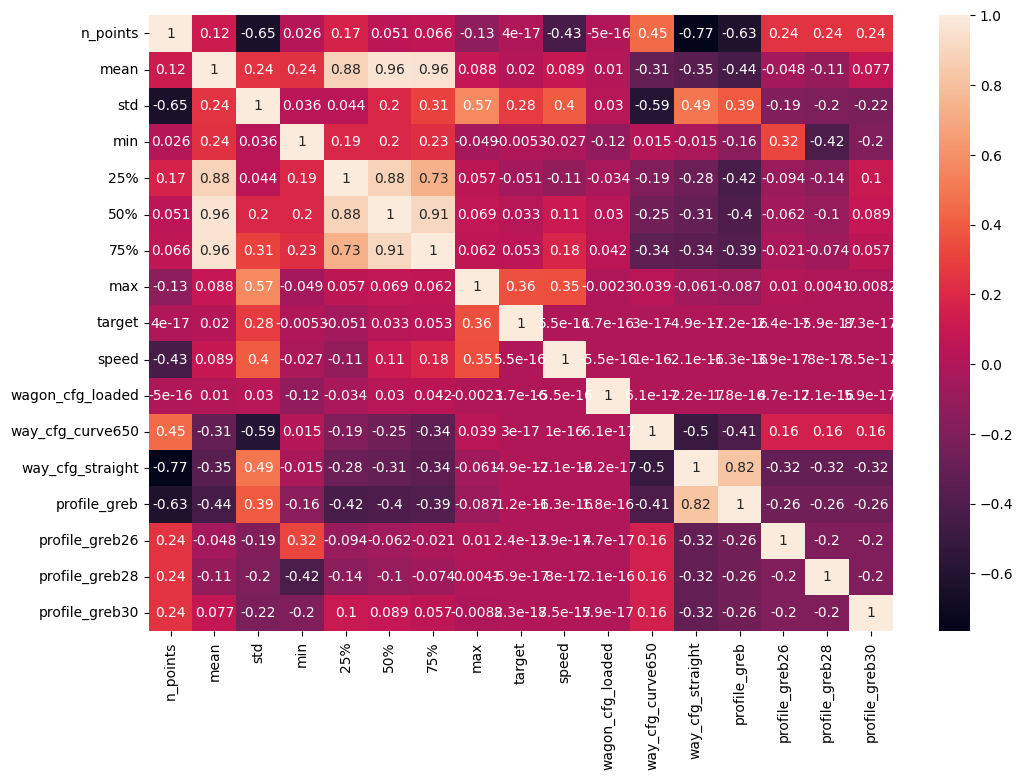

In [33]:

plt.figure().set_size_inches(12,8)
sns.heatmap(df.corr(),annot=True)
plt.show()

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

np.random.seed(32)

X = df.drop("target",axis=1)
y = df["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [35]:
xgb_pipe = Pipeline([("scaler",StandardScaler()),("model",XGBClassifier())])

xgb_pipe.fit(X_train,y_train)

print(classification_report(y_test,xgb_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.95      0.98      0.97        61

    accuracy                           0.95        87
   macro avg       0.96      0.93      0.94        87
weighted avg       0.95      0.95      0.95        87



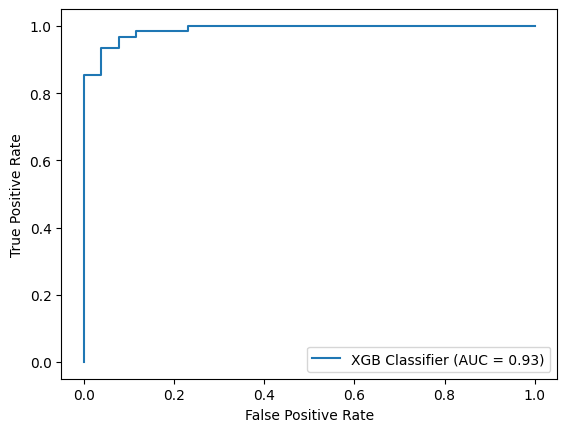

In [36]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=xgb_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=xgb_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="XGB Classifier")

display.plot()
plt.show()

**PCA TSNE**

In [37]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

X_embedded

array([[-26.732273  ,  -4.075675  ],
       [-28.26373   ,  -6.4303937 ],
       [-41.177746  , -14.7807455 ],
       [-43.102516  , -14.169646  ],
       [-45.601646  , -13.343474  ],
       [-47.396236  , -12.770797  ],
       [ 22.00397   , -20.81992   ],
       [ 25.180887  , -20.349463  ],
       [ 29.573805  , -18.705404  ],
       [ 52.16812   , -13.004544  ],
       [ 52.91466   , -15.573108  ],
       [ 53.44715   , -16.98212   ],
       [ 42.424427  , -64.43489   ],
       [ 42.711502  , -62.871624  ],
       [ 43.958256  , -66.68783   ],
       [ 42.75359   , -61.732826  ],
       [ 44.105206  , -66.097015  ],
       [ 44.43093   , -66.155876  ],
       [ 78.050896  ,   3.9109414 ],
       [ 76.06944   ,   0.46964356],
       [ 74.836044  ,  -2.2868204 ],
       [ 72.923584  ,  -8.472347  ],
       [ 73.02849   , -11.940193  ],
       [ 73.29931   , -12.922493  ],
       [-70.16129   , -35.197857  ],
       [-57.963654  ,  51.75601   ],
       [-58.187347  ,  52.231945  ],
 

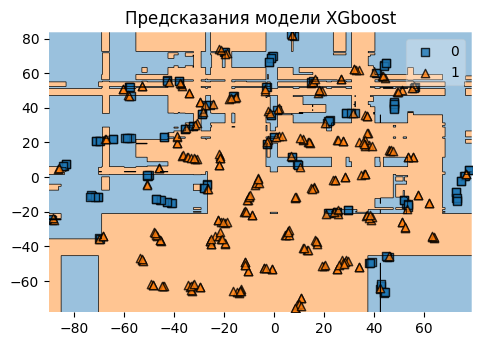

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf = XGBClassifier()


# Loading some example data

# print(X)
# print(y)

# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure().set_size_inches(12,8)

labels = ['Предсказания модели XGboost']
          

for clf, lab, grd in zip([clf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_embedded, y)
    
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_embedded, y=y.to_numpy(),
                                clf=clf, legend=1)
    plt.title(lab)

plt.show()

In [52]:
X.head().to_excel("пример для презентации.xlsx")